In [1]:
import tcrdist as td
import pandas as pd
import os
from tcrdist.repertoire import TCRrep
from tcrdist.proximity import TCRproximity
import numpy as np
import parasail
from collections import namedtuple
import matplotlib.pyplot as plt
from collections import defaultdict

Using Cython-powered Fisher's exact test


In [2]:
def get_auc(tr, target_epitope, nn_percentile):
    unique_epitopes = tr.clone_df['epitope'].unique()
    other_epitopes = list(set(unique_epitopes) - set(target_epitope))
    proxy = TCRproximity(tr, target_epitope, other_epitopes, nn_percentile=nn_percentile,
                         chain='beta', cdrs='cdr3', subjects_folds=None)
    return proxy.plot_ROC()['auc']

Database preparing

In [3]:
vdj = pd.read_csv('../vdjdb-dump/vdjdb_a02_4epi_trab_200.txt', sep='\t')
vdj_trb = vdj.loc[(vdj.gene == 'TRB')].copy()

# tcrdist has a specific naming format
# our mapping is not in default lib mappers
mapper = {'complex.id': 'complex_id', 'gene': 'gene', 'cdr3': 'cdr3_b_aa', 'v.segm': 'v_b_gene',
          'j.segm': 'j_b_gene', 'species': 'organism', 'mhc.a': 'mhc_b_a', 'mhc.b': 'mhc_b_b', 
          'mhc.class': 'mhc_b_class', 'antigen.epitope': 'epitope', 'antigen.gene': 'epitope_gene',
          'antigen.species': 'epitope_species', 'reference.id': 'reference', 'vdjdb.score': 'score'}

# dropping unnecessary variables (j.start, v.end) - they do not have corresponding names in the lib
vdj_trb.drop(set(vdj_trb.columns) - mapper.keys(), axis=1, inplace=True)

# renaming columns
vdj_trb.rename(mapper=mapper, axis=1, inplace=True)

In [4]:
tr = TCRrep(cell_df=vdj_trb, organism="human")
tr.infer_cdrs_from_v_gene(chain='beta', imgt_aligned=True)
tr.index_cols = ['epitope', 'cdr3_b_aa', 'cdr1_b_aa', 'cdr2_b_aa', 'pmhc_b_aa', 'v_b_gene', 'j_b_gene']
tr.cell_df['count'] = 1
tr.deduplicate()

/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:159: UserWarning: TRBV6-2*01,TRBV6-5*01 gene was not recognized in reference db no cdr seq could be inferred
  warnings.warn("{} gene was not recognized in reference db no cdr seq could be inferred".format(gene))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:159: UserWarning: TRBV6-5*01,TRBV2*01 gene was not recognized in reference db no cdr seq could be inferred
  warnings.warn("{} gene was not recognized in reference db no cdr seq could be inferred".format(gene))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:159: UserWarning: TRBV6-4*01,TRBV7-2*01 gene was not recognized in reference db no cdr seq could be inferred
  warnings.warn("{} gene was not recognized in reference db no cdr seq could be inferred".format(gene))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:159: UserWarning: TRBV6-3*01,TRBV6-2*01 gene was not recognized in reference db no cdr seq could be inf

tcrdist.repertoire.TCRrep for <Your TCR Repertoire Project>
 with index_cols: ['epitope', 'cdr3_b_aa', 'cdr1_b_aa', 'cdr2_b_aa', 'pmhc_b_aa', 'v_b_gene', 'j_b_gene']
 with model organism: human

In [5]:
DIRPATH = '../cdr3_substitutions/matrices/clmem'
EPITOPES = ['GILGFVFTL', 'LLLGIGILV', 'NLVPMVATV', 'LLWNGPMAV']
NN_PERCENTILE = 7

In [6]:
epitopes_auc = defaultdict(list)

#### BLOSUM62

/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

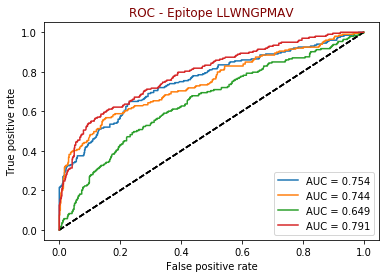

In [7]:
subst_matrix = parasail.blosum62
tr.compute_pairwise_all(chain="beta", metric="nw", processes=8, matrix=subst_matrix)
tr.compute_paired_tcrdist(store_result=True)

for epitope in EPITOPES:
    auc = get_auc(tr, epitope, NN_PERCENTILE)
    epitopes_auc[epitope].append((auc, 'blosum62'))

#### Aggregated TRA+TRB/TRB matrices

cons62x62_sample100.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

cons62x40_sample50.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

cons62x80_sampleNone.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

cons62x62_sampleNone.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

cons62x62_sample50.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

cons40x40_sampleNone.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

cons40x80_sample100.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

cons40x40_sample50.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

cons40x40_sample100.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

cons40x62_sample50.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

cons40x80_sampleNone.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

cons40x62_sampleNone.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

cons62x40_sampleNone.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

cons62x40_sample100.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

cons62x80_sample50.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

cons40x62_sample100.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

cons40x80_sample50.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

cons62x80_sample100.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

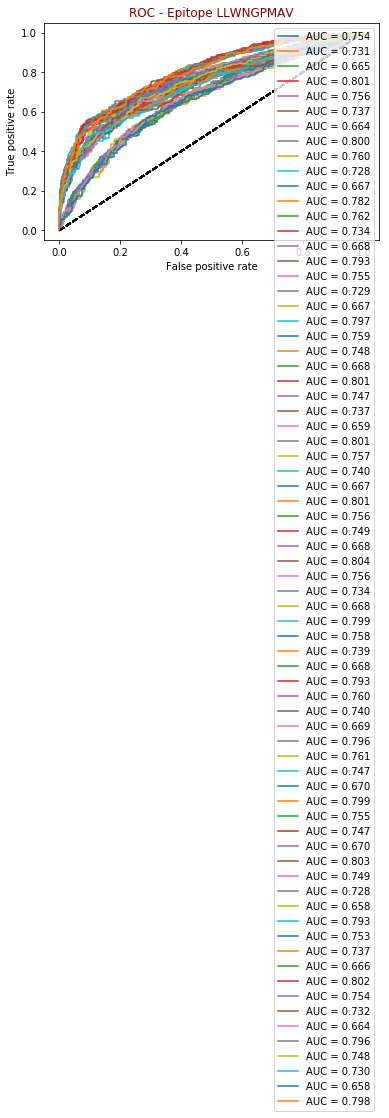

In [11]:
for matrix_name in os.listdir(os.path.join(DIRPATH, 'both')):
    print(matrix_name)
    subst_matrix = parasail.Matrix(os.path.join(DIRPATH, 'both', matrix_name))
    tr.compute_pairwise_all(chain="beta", metric="nw", processes=8, matrix=subst_matrix)
    tr.compute_paired_tcrdist(store_result=True)
    for epitope in EPITOPES:
        auc = get_auc(tr, epitope, NN_PERCENTILE)
        epitopes_auc[epitope].append((auc, matrix_name))

cons40_sample50.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

cons62_sample50.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

cons62_sampleNone.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

cons62_sample100.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

cons40_sampleNone.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

cons40_sample100.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

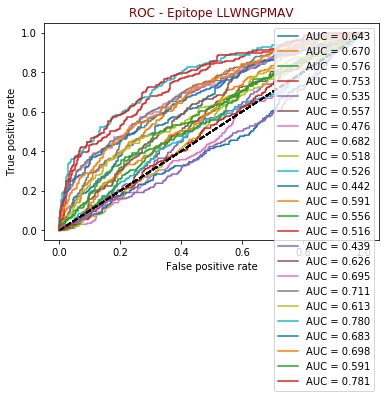

In [12]:
for matrix_name in os.listdir(os.path.join(DIRPATH, 'trb')):
    print(matrix_name)
    subst_matrix = parasail.Matrix(os.path.join(DIRPATH, 'trb', matrix_name))
    tr.compute_pairwise_all(chain="beta", metric="nw", processes=4, matrix=subst_matrix)
    tr.compute_paired_tcrdist(store_result=True)
    for epitope in EPITOPES:
        auc = get_auc(tr, epitope, NN_PERCENTILE)
        epitopes_auc[epitope].append((auc, matrix_name))

#### Epitope-specific TRA+TRB/TRB matrices

gilgfvftl_both_cons62x62.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

gilgfvftl_both_cons40x62.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

gilgfvftl_trb_cons80.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

gilgfvftl_trb_cons40.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

gilgfvftl_both_cons40x80.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

gilgfvftl_both_cons40x40.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

gilgfvftl_trb_cons62.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

gilgfvftl_both_cons62x40.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

gilgfvftl_both_cons62x80.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

nlvpmvatv_both_cons62x62.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

nlvpmvatv_both_cons40x62.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

nlvpmvatv_trb_cons80.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

nlvpmvatv_trb_cons40.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

nlvpmvatv_both_cons40x80.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

nlvpmvatv_both_cons40x40.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

nlvpmvatv_trb_cons62.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

nlvpmvatv_both_cons62x40.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

nlvpmvatv_both_cons62x80.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

llwngpmav_trb_cons80.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

llwngpmav_trb_cons40.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

llwngpmav_trb_cons62.csv


/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr1_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr2_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/bio/immune_project/tcrdist/tcrdist/repertoire.py:668: UserWarning: tcrdist was calculated without: 'cdr3_a_aa_pw' because pairwise distances haven't been computed for this region:
  warnings.warn("tcrdist was calculated without: '{}' because pairwise distances haven't been computed for this region:".format(k))
/Users/nediolus/

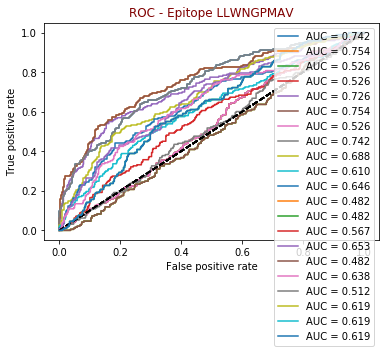

In [13]:
for epitope in EPITOPES:
    for matrix_name in os.listdir(os.path.join(DIRPATH, 'epitopes', epitope)):
        if matrix_name.startswith('tra'):
            continue
        subst_matrix = parasail.Matrix(os.path.join(DIRPATH, 'epitopes', epitope, matrix_name))
        matrix_name = f'{epitope.lower()}_{matrix_name}'
        print(matrix_name)
        tr.compute_pairwise_all(chain="beta", metric="nw", processes=4, matrix=subst_matrix)
        tr.compute_paired_tcrdist(store_result=True)
        auc = get_auc(tr, epitope, NN_PERCENTILE)
        epitopes_auc[epitope].append((auc, matrix_name))

#### Top 10 best matrices for every epitope

In [15]:
for epitope in EPITOPES:
    print(epitope)
    scores = sorted(epitopes_auc[epitope], reverse=True)
    for auc, name in scores[0:30]:
        print(f'\t{auc}, {name}')

GILGFVFTL
	0.7621355932203389, cons62x62_sampleNone.csv
	0.7609745762711865, cons62x40_sampleNone.csv
	0.7603135593220339, cons40x62_sampleNone.csv
	0.7601949152542373, cons62x80_sampleNone.csv
	0.7590932203389831, cons40x40_sampleNone.csv
	0.7581694915254237, cons40x80_sampleNone.csv
	0.7569110169491524, cons40x40_sample50.csv
	0.7559830508474576, cons40x62_sample50.csv
	0.7557542372881356, cons62x40_sample50.csv
	0.7556440677966102, cons40x40_sample100.csv
	0.7551694915254238, cons62x40_sample100.csv
	0.7549999999999999, cons62x62_sample50.csv
	0.7541694915254237, gilgfvftl_both_cons40x62.csv
	0.7541694915254237, gilgfvftl_both_cons40x40.csv
	0.754093220338983, cons40x80_sample50.csv
	0.7540466101694916, blosum62
	0.7537288135593221, cons62x62_sample100.csv
	0.7526610169491526, cons40x62_sample100.csv
	0.7490338983050848, cons62x80_sample50.csv
	0.7481906779661016, cons62x80_sample100.csv
	0.7469830508474576, cons40x80_sample100.csv
	0.7415084745762712, gilgfvftl_both_cons62x62.csv
	

In [17]:
matrix2score = defaultdict(list)
for epitope in EPITOPES:
    scores = sorted(epitopes_auc[epitope], reverse=True)
    for auc, name in scores:
        matrix2score[name].append(auc)
from collections import Counter
matrix2avg = Counter()
for matrix, scores in matrix2score.items():
    matrix2avg[matrix] = np.average(scores)
    
for matrix, avg in matrix2avg.most_common():
    print(matrix, avg)

gilgfvftl_both_cons40x62.csv 0.7541694915254237
gilgfvftl_both_cons40x40.csv 0.7541694915254237
cons62x40_sampleNone.csv 0.7443609428313414
cons40x40_sample100.csv 0.744141878510409
cons40x40_sampleNone.csv 0.7440355970421499
cons62x40_sample100.csv 0.7437301253450843
gilgfvftl_both_cons62x62.csv 0.7415084745762712
gilgfvftl_both_cons62x40.csv 0.7415084745762712
cons40x62_sampleNone.csv 0.7413154814692451
cons40x40_sample50.csv 0.7412734968957689
cons40x62_sample50.csv 0.7393243183091617
cons40x80_sampleNone.csv 0.7392890204414322
cons62x62_sampleNone.csv 0.7391755219370959
cons62x40_sample50.csv 0.7391582818391698
cons40x62_sample100.csv 0.7391471275062916
cons62x62_sample100.csv 0.7378254746486945
cons62x62_sample50.csv 0.7370206462886681
cons40x80_sample50.csv 0.7365632678753924
cons40x80_sample100.csv 0.7359391357263931
blosum62 0.734605537405091
cons62x80_sampleNone.csv 0.7342752812801818
cons62x80_sample100.csv 0.7335436108580717
cons62x80_sample50.csv 0.7318171128575839
gilgfvft